<a href="https://colab.research.google.com/github/zarrinan/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=159.74136990402116, mobile=True), User(purchased=False, time_on_site=16.55963897321514, mobile=True), User(purchased=False, time_on_site=194.56734169565823, mobile=True), User(purchased=False, time_on_site=254.21851348739744, mobile=False), User(purchased=False, time_on_site=277.1222740430545, mobile=True), User(purchased=False, time_on_site=499.61087036420065, mobile=False), User(purchased=False, time_on_site=261.96965883461434, mobile=True), User(purchased=False, time_on_site=493.12941572931027, mobile=False), User(purchased=False, time_on_site=356.4834584351512, mobile=False), User(purchased=False, time_on_site=225.44241409085774, mobile=False)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,159.741370,True
1,False,16.559639,True
2,False,194.567342,True
3,False,254.218513,False
4,False,277.122274,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.107303982638431,5.117192195074757,5.140169958961082,5.648417438572876,6.773985297985985,7.3192232936693244,8.272377319550717,8.282479479187222,9.077469009901012,9.94891954995849,...,563.6816474828483,565.3230890313552,579.1143261403222,582.5080743089092,582.7321996849422,585.011673436378,587.7609463283121,589.2636217544971,591.5009429493471,593.1793257005122
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,0,1,0,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
True,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.519, 122.722]","(122.722, 240.336]","(240.336, 357.951]","(357.951, 475.565]","(475.565, 593.179]"
purchased,,,,,
False,266,286,170,40,44
True,78,74,34,4,4


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.519, 122.722]","(122.722, 240.336]","(240.336, 357.951]","(357.951, 475.565]","(475.565, 593.179]"
purchased,,,,,
False,0.773256,0.794444,0.833333,0.909091,0.916667
True,0.226744,0.205556,0.166667,0.090909,0.083333


In [8]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.888,0.778667
True,0.112,0.221333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


In [13]:
persons_url = 'https://raw.githubusercontent.com/zarrinan/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
df = pd.read_csv(persons_url, index_col=0)
print(df.shape)
print(df.describe(include='all'))
df.info()

(1200, 3)
               age       weight  exercise_time
count  1200.000000  1200.000000    1200.000000
mean     48.396667   153.540833     134.910833
std      18.166802    35.132182      85.548895
min      18.000000   100.000000       0.000000
25%      33.000000   125.000000      65.000000
50%      48.000000   149.000000     122.000000
75%      64.000000   180.250000     206.000000
max      80.000000   246.000000     300.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 3 columns):
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(3)
memory usage: 37.5 KB


In [0]:
age = df['age']
weight = df['weight']
exercise_time = df['exercise_time']

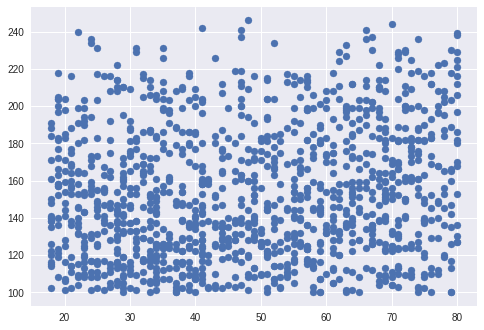

In [21]:
import matplotlib.pyplot as plt
plt.scatter(age, weight)  

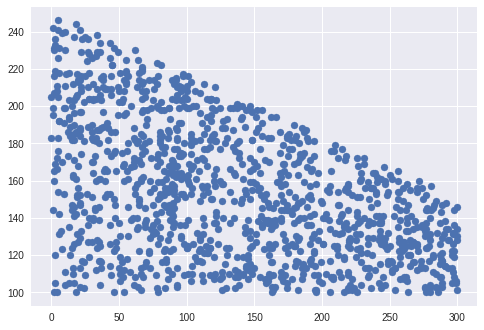

In [22]:
 plt.scatter(exercise_time, weight)

In [0]:
age_bins = pd.cut(age, 6)
exercise_bins = pd.cut(exercise_time, 5)
weight_bins = pd.cut(weight, 5)

In [55]:
ds = pd.crosstab([weight_bins, age_bins], exercise_bins, normalize='columns')
ds


exercise_time                     (-0.3, 60.0]  (60.0, 120.0]  (120.0, 180.0]  \
weight          age                                                             
(99.854, 129.2] (17.938, 28.333]      0.028777       0.025316        0.053812   
                (28.333, 38.667]      0.032374       0.050633        0.085202   
                (38.667, 49.0]        0.010791       0.025316        0.026906   
                (49.0, 59.333]        0.028777       0.015823        0.058296   
                (59.333, 69.667]      0.021583       0.031646        0.044843   
                (69.667, 80.0]        0.068345       0.056962        0.049327   
(129.2, 158.4]  (17.938, 28.333]      0.010791       0.041139        0.085202   
                (28.333, 38.667]      0.039568       0.015823        0.022422   
                (38.667, 49.0]        0.028777       0.031646        0.058296   
                (49.0, 59.333]        0.010791       0.025316        0.035874   
                (59.333, 69.667]      0.025180       0.053797        0.076233   
                (69.667, 80.0]        0.043165       0.072785        0.022422   
(158.4, 187.6]  (17.938, 28.333]      0.021583       0.034810        0.035874   
                (28.333, 38.667]      0.043165       0.031646        0.058296   
                (38.667, 49.0]        0.025180       0.050633        0.035874   
                (49.0, 59.333]        0.032374       0.037975        0.040359   
                (59.333, 69.667]      0.032374       0.053797        0.035874   
                (69.667, 80.0]        0.064748       0.085443        0.044843   
(187.6, 216.8]  (17.938, 28.333]      0.046763       0.025316        0.031390   
                (28.333, 38.667]      0.057554       0.031646        0.008969   
                (38.667, 49.0]        0.035971       0.031646        0.008969   
                (49.0, 59.333]        0.028777       0.037975        0.031390   
                (59.333, 69.667]      0.053957       0.063291        0.026906   
                (69.667, 80.0]        0.050360       0.041139        0.022422   
(216.8, 246.0]  (17.938, 28.333]      0.025180       0.000000        0.000000   
                (28.333, 38.667]      0.017986       0.000000        0.000000   
                (38.667, 49.0]        0.028777       0.000000        0.000000   
                (49.0, 59.333]        0.003597       0.003165        0.000000   
                (59.333, 69.667]      0.032374       0.003165        0.000000   
                (69.667, 80.0]        0.050360       0.022152        0.000000   

exercise_time                     (180.0, 240.0]  (240.0, 300.0]  
weight          age                                               
(99.854, 129.2] (17.938, 28.333]        0.078125        0.120419  
                (28.333, 38.667]        0.104167        0.109948  
                (38.667, 49.0]          0.088542        0.178010  
                (49.0, 59.333]          0.078125        0.136126  
                (59.333, 69.667]        0.057292        0.015707  
                (69.667, 80.0]          0.005208        0.000000  
(129.2, 158.4]  (17.938, 28.333]        0.130208        0.057592  
                (28.333, 38.667]        0.072917        0.099476  
                (38.667, 49.0]          0.052083        0.094241  
                (49.0, 59.333]          0.041667        0.115183  
                (59.333, 69.667]        0.083333        0.020942  
                (69.667, 80.0]          0.005208        0.000000  
(158.4, 187.6]  (17.938, 28.333]        0.052083        0.010471  
                (28.333, 38.667]        0.041667        0.010471  
                (38.667, 49.0]          0.036458        0.026178  
                (49.0, 59.333]          0.036458        0.005236  
                (59.333, 69.667]        0.031250        0.000000  
                (69.667, 80.0]          0.000000        0.000000  
(187.6, 216.8]  (17.938, 28.333]        0.000000        0.000000  


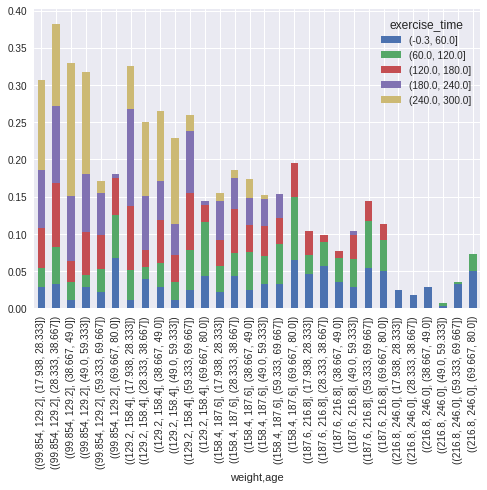

In [56]:
ds.plot(kind='bar', stacked=True)

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)